## Практическое задание 3: Линейные модели, часть 2: Классификация

## Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

In [1]:
! pip install scikit-learn pandas numpy seaborn matplotlib gdown

Defaulting to user installation because normal site-packages is not writeable


In [2]:
! gdown 1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199

Downloading...
From: https://drive.google.com/uc?id=1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199
To: c:\Users\jingni\Documents\Codes\sch57\i-love-crispy-laptops\ML\ML 3 - Log\requirements_small.txt

  0%|          | 0.00/374 [00:00<?, ?B/s]
100%|██████████| 374/374 [00:00<00:00, 835kB/s]


Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2023"></font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
%matplotlib inline

## Часть 1. Классификация

Напомним, что бинарная линейная классификация с классами $0$ и $1$ &mdash; это модель следующего вида:
$a(x)= \begin{cases}
1, & \langle w, x \rangle + b > 0; \\
0, & \text{иначе.}
\end{cases}$

где  $w \in \mathbb{R}^d$,  $b \in \mathbb{R}$. В логистической регрессии $p(x) = \frac{1}{1 + e^{-[\langle w, x \rangle + b]}}$ интерпретируется как вероятность принадлежности к первому классу. Если объект $x$ принадлежит классу $1$ с вероятностью $p(x)$, то правдоподобие записывается в виде $\prod_{i=1}^{n} p(x_i)^{y_i} \cdot \left( 1 - p(x_i) \right)^{1 - y_i}$. Обучить логистическую регрессию означает найти параметры $w$ и $b$, которые максимизируют указанное правдоподобие. Что эквивалентно минимизации $- \sum_{i=1}^n y_i \log p(x_i) + (1 - y_i) \log (1 - p(x_i))$. Указанная функция потерь называет логистической (или логлосс).

По тем же причинам, что и в линейной регрессии, к логистической функции потерь добавляется регуляризация (стандартно это $l_2$).

### **Вопрос 1** (1 балл)

Можно ли использовать  $𝑙_1$  регуляризацию в логистической регрессии?

***Ваш ответ здесь***

Рассмотрим пару модельных примеров, в которых целевая переменная $y$ линейно зависит от двух независимых величин $x_1$ и $x_2$, плюс случайный шум.

In [2]:
np.random.seed(1)
X = np.random.randn(100, 2)
Y = np.random.randn(100) * 1. + X[:, 0] * 3 - X[:, 1] * 0.12
Y = np.where(Y > 0, 1, 0)

Обучим логистическую регрессию, двумя методами LBFGS и Newton-CG. Для простоты восприятия, можно считать, что первый похож на градиентный спуск, а второй на метод Ньютона

In [3]:
from sklearn.linear_model import LogisticRegression

clf_lbfgs = LogisticRegression(C=1, solver='lbfgs', max_iter=1, warm_start=True, fit_intercept=False)
clf_newton_cg = LogisticRegression(C=1, solver='newton-cg', max_iter=1, warm_start=True, fit_intercept=False)

coefs_lbfgs = []
coefs_nc = []

for it in range(1000):
    clf_lbfgs.fit(X, Y)
    coefs_lbfgs.append(clf_lbfgs.coef_[0])
    clf_newton_cg.fit(X, Y)
    coefs_nc.append(clf_newton_cg.coef_[0])

coefs_lbfgs = np.array(coefs_lbfgs)
coefs_nc = np.array(coefs_nc)

In [4]:
x1 = np.linspace(0.5, 3.5, 1000)
x2 = np.linspace(-0.5, -0.1, 1000)
X1, X2 = np.meshgrid(x1, x2)

def loss(X1, X2, X, Y):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    p = sigmoid(X1[None] * X[:, 0, None, None] + X2[None] * X[:, 1, None, None]) # 100, 200, 200
    return -np.sum(Y[:, None, None] * np.log(p) + (1 - Y[:, None, None]) * np.log(1 - p), axis=0) + 0.5 * (X1**2 + X2**2)

Z = loss(X1, X2, X, Y)

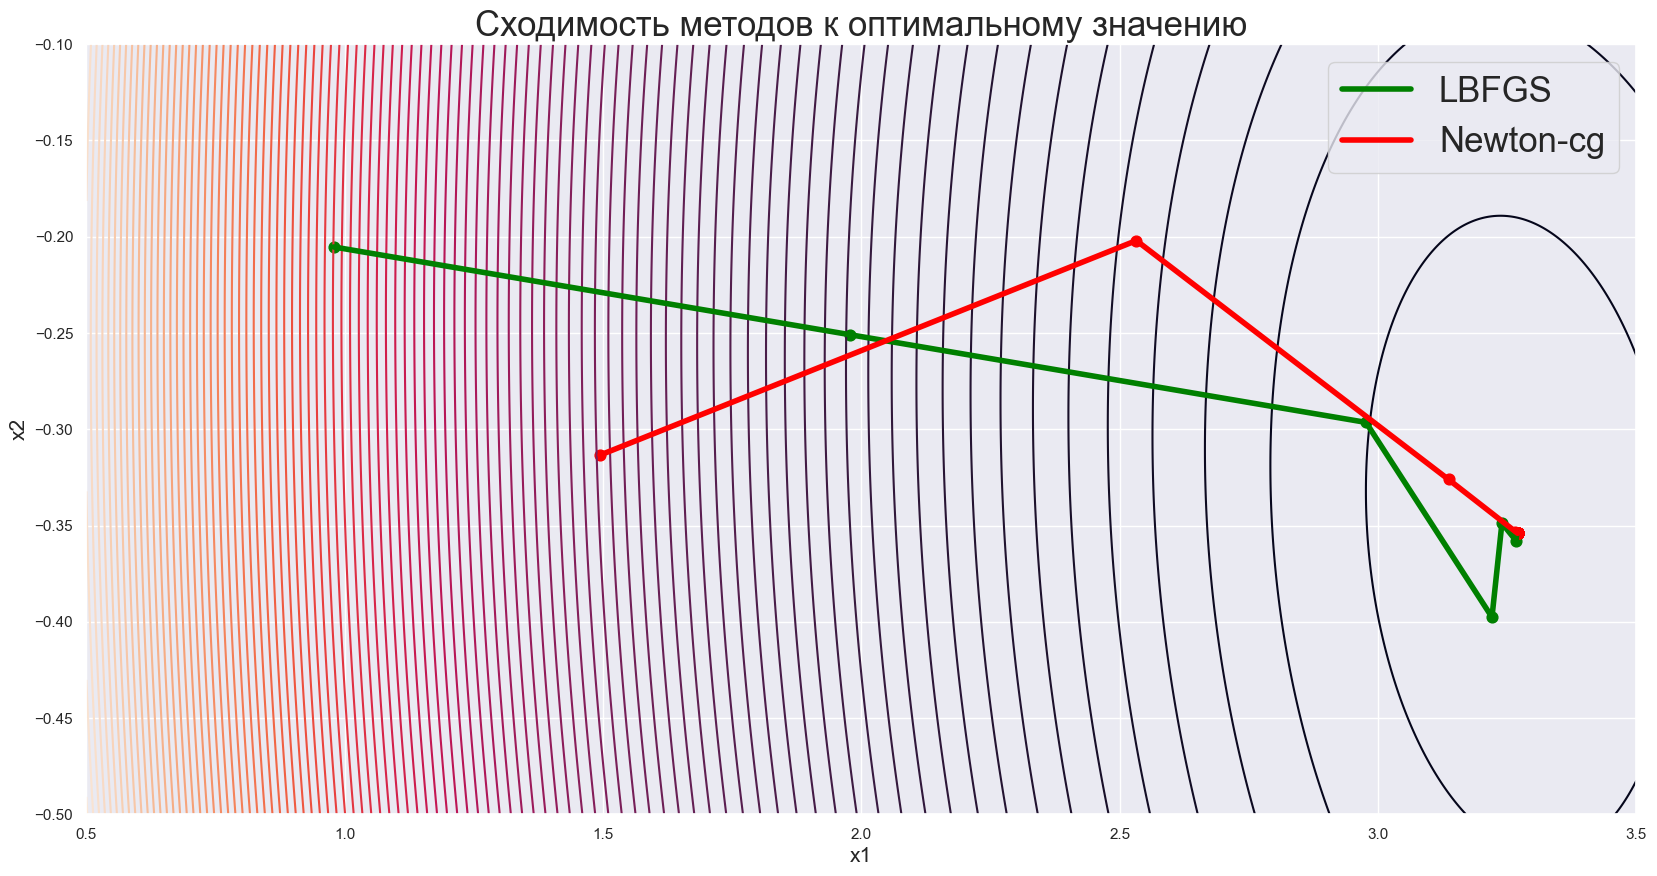

In [5]:
sns.set(style="darkgrid")
plt.figure(figsize=(20, 10))
plt.contour(X1, X2, Z, levels=100)
plt.plot(coefs_lbfgs[:, 0], coefs_lbfgs[:, 1], color="green", linewidth=4, label="LBFGS")
plt.scatter(coefs_lbfgs[:, 0], coefs_lbfgs[:, 1], color="green", s=60)
plt.plot(coefs_nc[:, 0], coefs_nc[:, 1], color="red", linewidth=4, label="Newton-cg")
plt.scatter(coefs_nc[:, 0], coefs_nc[:, 1], color="red", s=60)
plt.legend(fontsize=25)
plt.xlabel("x1", size=15)
plt.ylabel("x2", size=15)
plt.title("Сходимость методов к оптимальному значению", size=25)
plt.show()

Рассмотрим второй пример. **Внимание**, здесь $x_2$ уже из другого распределения!

In [6]:
np.random.seed(1)
X = np.hstack((np.random.randn(100, 1), np.random.uniform(7, 12, (100, 1))))
Y = np.random.randn(100) * 1. + X[:, 0] * 3 - X[:, 1] * 0.12
Y = np.where(Y > 0, 1, 0)

In [7]:
clf_lbfgs = LogisticRegression(C=1, solver='lbfgs', max_iter=1, warm_start=True, fit_intercept=False)
clf_newton_cg = LogisticRegression(C=1, solver='newton-cg', max_iter=1, warm_start=True, fit_intercept=False)

coefs_lbfgs = []
coefs_nc = []

for it in range(1000):
    clf_lbfgs.fit(X, Y)
    coefs_lbfgs.append(clf_lbfgs.coef_[0])
    clf_newton_cg.fit(X, Y)
    coefs_nc.append(clf_newton_cg.coef_[0])

coefs_lbfgs = np.array(coefs_lbfgs)
coefs_nc = np.array(coefs_nc)

x1 = np.linspace(0, 3.5, 1000)
x2 = np.linspace(0.01, -0.1, 1000)
X1, X2 = np.meshgrid(x1, x2)
Z = loss(X1, X2, X, Y)

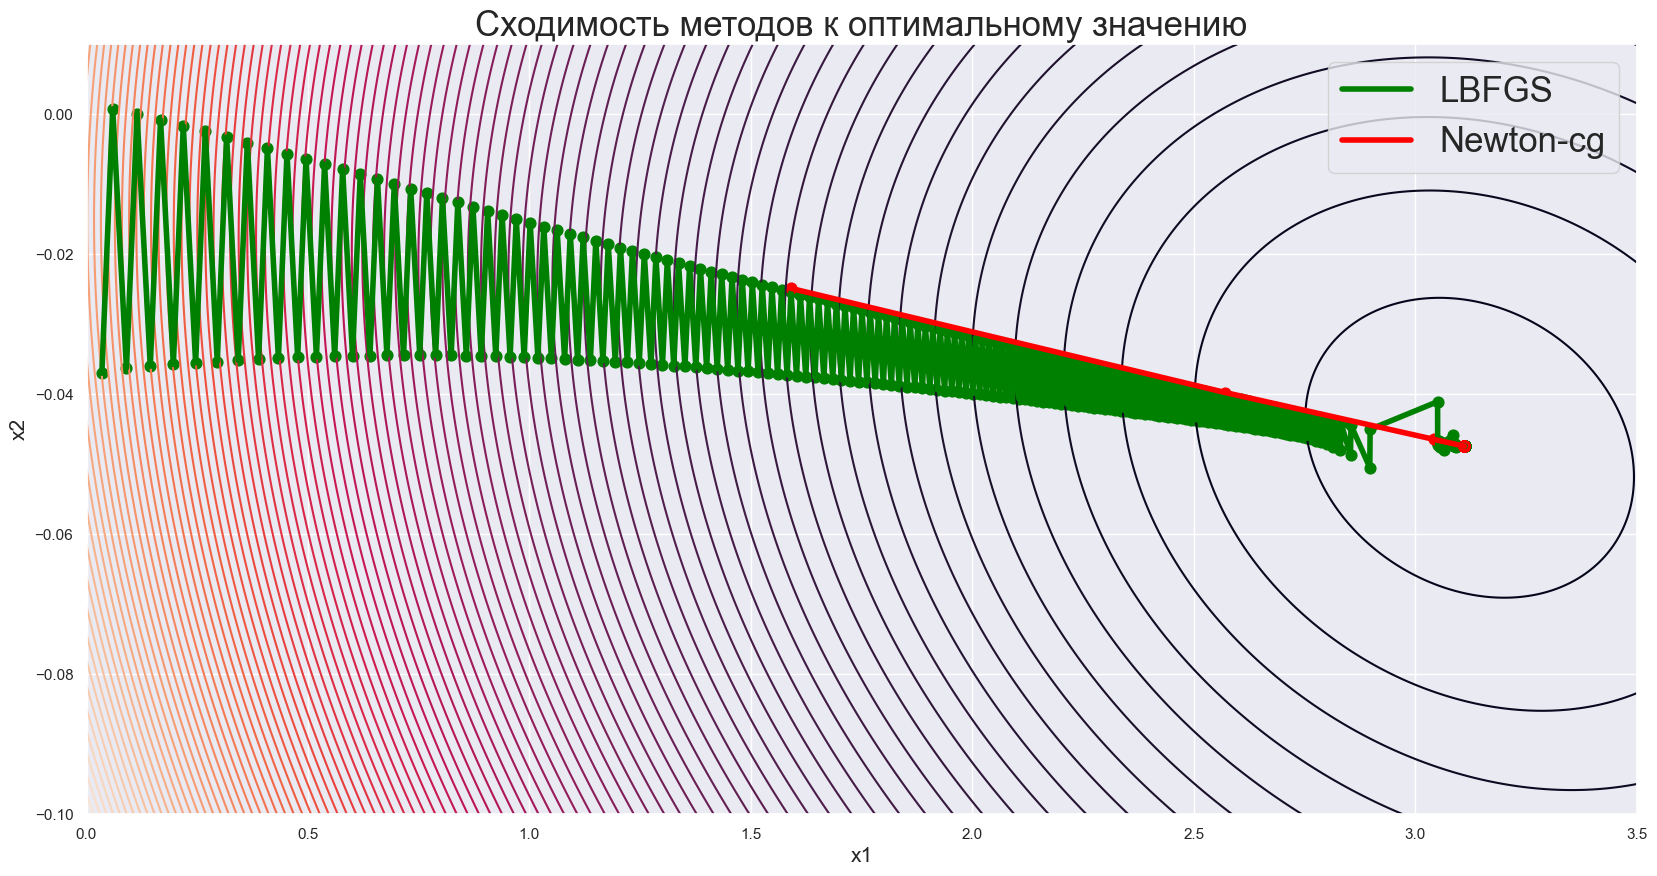

In [8]:
sns.set(style="darkgrid")
plt.figure(figsize=(20, 10))
plt.contour(X1, X2, Z, levels=100)
plt.plot(coefs_lbfgs[:, 0], coefs_lbfgs[:, 1], color="green", linewidth=4, label="LBFGS")
plt.scatter(coefs_lbfgs[:, 0], coefs_lbfgs[:, 1], color="green", s=60)
plt.plot(coefs_nc[:, 0], coefs_nc[:, 1], color="red", linewidth=4, label="Newton-cg")
plt.scatter(coefs_nc[:, 0], coefs_nc[:, 1], color="red", s=60)
plt.legend(fontsize=25)
plt.xlabel("x1", size=15)
plt.ylabel("x2", size=15)
plt.title("Сходимость методов к оптимальному значению", size=25)
plt.show()

### **Вопрос 2** (2 балла)

Как видим, метод LBFGS плохо работает на неотмасштабированных данных. Это общее свойство всех методов первого порядка (т.е. использующих только первую производную). Ньютоновские же методы хорошо справляются с подобными ситуациями. В таком случае, почему LBFGS является методом по умолчанию, а не Newton-CG?

***Ваш ответ здесь***

Давайте рассмотрим ещё один модельный пример.

$x_1 \sim Uniform(0, 1)$, $x_2 \sim Uniform(0, 1)$

$y(x_1, x_2)= \begin{cases}
0, & x_1 + x_2 < 5; \\
1, & \text{иначе.}
\end{cases}$

Сгенерируем данные и выучим логистическую регрессию, визуализировав полученный результат.

In [9]:
np.random.seed(1)
X1 = np.random.uniform(0, 5, 100)
X2 = np.random.uniform(0, 5, 100)
X = np.hstack((X1[:, None], X2[:, None]))
Y = np.where(X1 + X2 < 5, 0, 1)

In [10]:
clf = LogisticRegression(penalty='l2')
clf.fit(X, Y)

LogisticRegression()

In [11]:
from matplotlib.colors import ListedColormap

def plot_separating_surface(X, y, cls, view_support=False):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(8, 8))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1],
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.title("Визуализация прогнозатора", size=15)
    plt.xlabel(r'$x_1$', size=15)
    plt.ylabel(r'$x_2$', size=15)

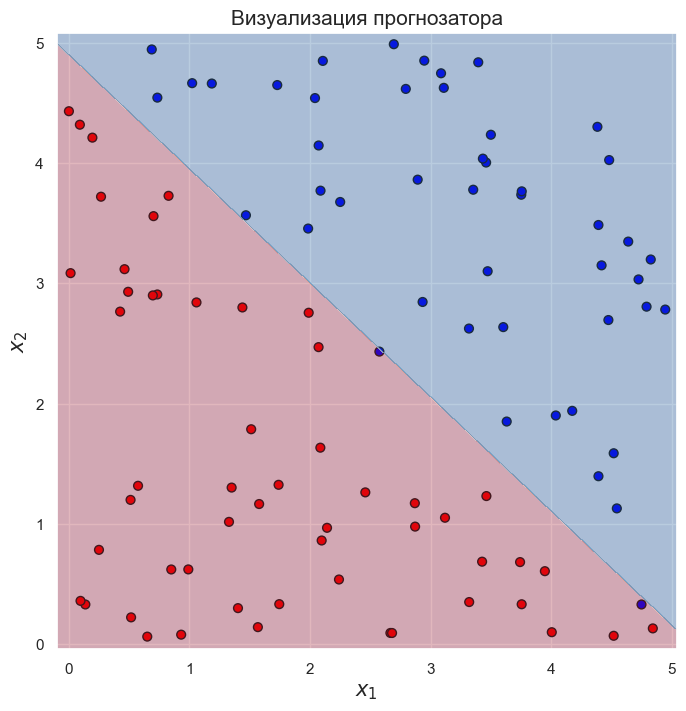

In [12]:
plot_separating_surface(X, Y, clf)

### **Вопрос 3** (2 балла)

Придумайте, сгенерируйте и визуализируйте пример, в котором логистическая регрессия будет плохо классифицировать данные.

**Ваш ответ здесь**

In [13]:
#Ваш ответ здесь

Представьте, что в одном из наших модельных примеров произошла ошибка, данные были испорчены, и теперь у нас вместо $100$ разных сэмплов &mdash; $100$ копий одного сэмпла. Например, так.

In [14]:
X1 = []
X2 = []

for i in range(100):
    np.random.seed(1)
    x1 = np.random.uniform(0, 5)
    x2 = np.random.uniform(0, 5)
    X1.append(x1)
    X2.append(x2)

X1 = np.array(X1)
X2 = np.array(X2)
X = np.hstack((X1[:, None], X2[:, None]))

Y = []

for i in range(100):
    p = 1 / (1 + np.exp(-(X1[i] + X2[i] - 5)))
    y = np.random.choice([0, 1], p = [1 - p, p])
    Y.append(y)

Y = np.array(Y)

### **Вопрос 4** (1 балл)

Почему в этом коде генерируется $100$ одинаковых примеров, хотя используется random?

***Ваш ответ здесь***

-----------
<font color="white" style="opacity:0.2023"></font>

Поскольку все записи у нас идентичны, то каждому объекту обучающей выборки логистическая регрессия предскажет одинаковую вероятность принадлежности к классу $1$.

## Обучение на реальных данных

Рассмотрим набор данных от метеорологической службы одной страны. В нём требуется предсказать, будет ли дождь на следующий день.

Для начала, скачаем данные

In [15]:
!gdown 1AgUMxgMK-eRjzthevCk9g-J_s2vpBFpe

Downloading...
From: https://drive.google.com/uc?id=1AgUMxgMK-eRjzthevCk9g-J_s2vpBFpe
To: c:\Users\jingni\Documents\Codes\sch57\i-love-crispy-laptops\ML\ML 3 - Log\weatherAUS.csv

  0%|          | 0.00/14.1M [00:00<?, ?B/s]
  4%|▎         | 524k/14.1M [00:00<00:14, 960kB/s]
  7%|▋         | 1.05M/14.1M [00:00<00:10, 1.21MB/s]
 11%|█         | 1.57M/14.1M [00:01<00:09, 1.31MB/s]
 15%|█▍        | 2.10M/14.1M [00:01<00:08, 1.47MB/s]
 19%|█▊        | 2.62M/14.1M [00:01<00:07, 1.52MB/s]
 22%|██▏       | 3.15M/14.1M [00:02<00:07, 1.53MB/s]
 26%|██▌       | 3.67M/14.1M [00:02<00:07, 1.47MB/s]
 30%|██▉       | 4.19M/14.1M [00:02<00:06, 1.49MB/s]
 33%|███▎      | 4.72M/14.1M [00:03<00:06, 1.52MB/s]
 37%|███▋      | 5.24M/14.1M [00:03<00:06, 1.47MB/s]
 41%|████      | 5.77M/14.1M [00:03<00:05, 1.54MB/s]
 45%|████▍     | 6.29M/14.1M [00:04<00:04, 1.61MB/s]
 48%|████▊     | 6.82M/14.1M [00:04<00:04, 1.61MB/s]
 52%|█████▏    | 7.34M/14.1M [00:04<00:04, 1.54MB/s]
 56%|█████▌    | 7.86M/14.1M [00:05<

In [16]:
df = pd.read_csv("weatherAUS.csv")
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


### **Вопрос 5** (1 балл)

Что это за страна? Подсказка: жители этой страны воспользовались бы методом tail вместо head :)

***Ваш ответ здесь***

Извлечём немного информации из набора данных

In [17]:
df.shape

(145460, 23)

In [18]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

Внимательно приглядимся к столбцам. Напомним, что мы предсказываем значение RainTomorrow. Давайте посмотрим, на этот столбец

In [19]:
df['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

Целевая переменная содержит неопределённые значения! Их нужно удалить из всей выборки. Также, переименуем 'Yes' и 'No' в $1$ и $0$.

In [20]:
df = df[df['RainTomorrow'] == df['RainTomorrow']]
df['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

In [21]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1., 'No': 0.})
df['RainToday'] = df['RainToday'].map({'Yes': 1., 'No': 0.})

In [22]:
print(df.shape)

(142193, 23)


Объектов стало чуть-чуть поменьше. Давайте выведем немного информации о них

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null   fl

Как видим, у нас есть 17 признаков имеющих вещественные значения (вещественные признаки), и 5 признаков типа object (категориальные признаки). Для них требуется отдельная предобработка. Пока разобьём выборку на обучающую и тестовую.

In [24]:
from sklearn.model_selection import train_test_split

<img src="https://img.devrant.com/devrant/rant/r_2416968_UUKQJ.jpg" width=360 height=760 />

In [25]:
y = df.RainTomorrow
X = df.drop(columns=["RainTomorrow"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

In [26]:
X_train.shape

(99535, 22)

#### Вещественные признаки

Как вы могли заметить, среди вещественных и категориальных признаков есть пропущенные значения. В случае с вещественными признаками, пропущенные значения заполняют средним, медианой, нулём или даже пытаются предсказывать по другим признакам. Мы заполним медианой

In [27]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_median = numeric_data.median()
numeric_features = numeric_data.columns
X_train = X_train.fillna(numeric_data_median)
X_test = X_test.fillna(numeric_data_median)

In [28]:
len(numeric_features)

17

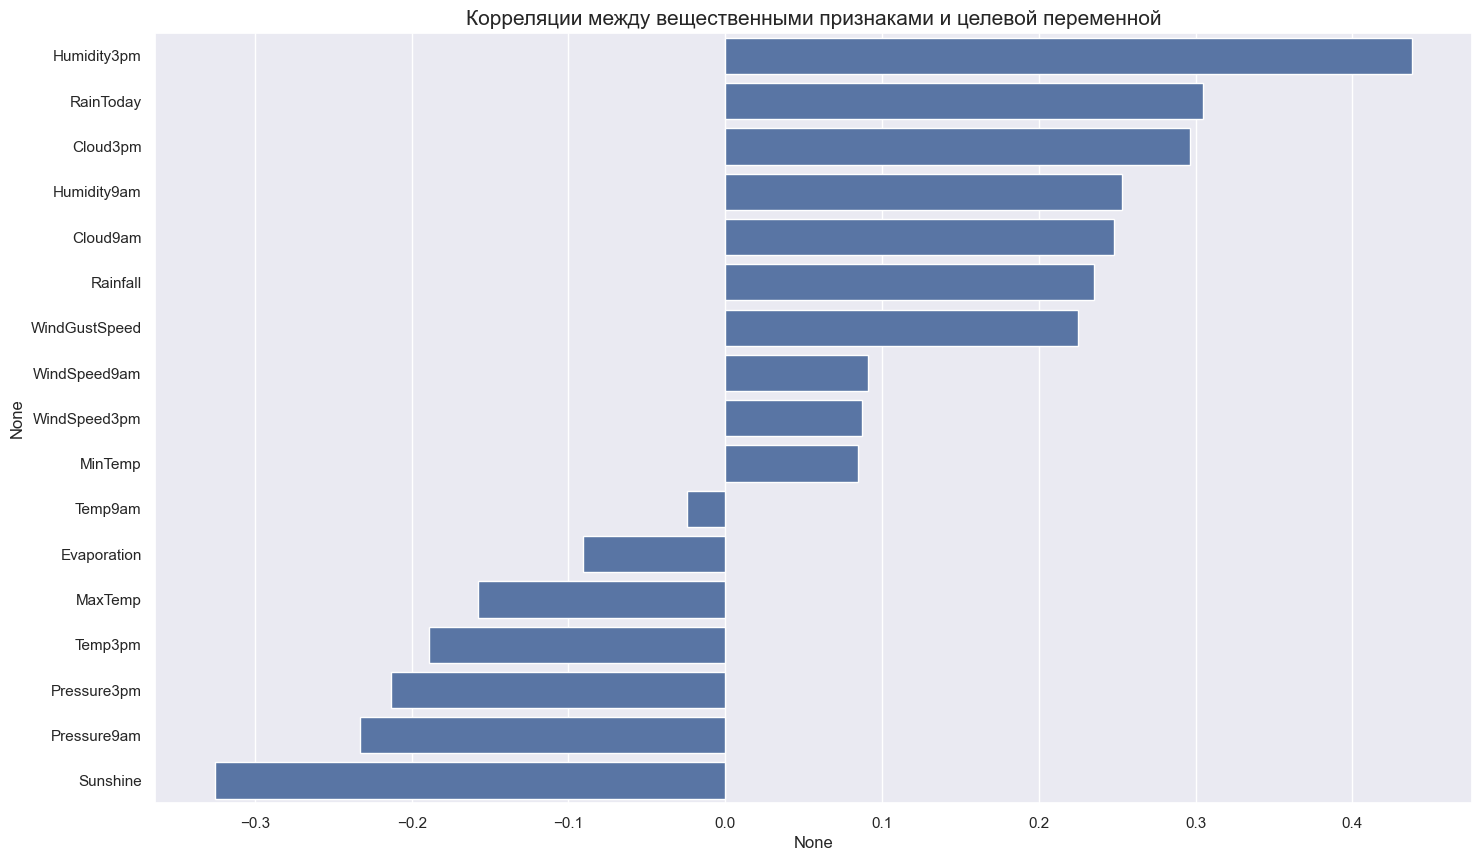

In [29]:
correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.set_title("Корреляции между вещественными признаками и целевой переменной", size=15)
plot.figure.set_size_inches(17, 10)

### **Вопрос 6** (2 балла)

Попробуйте объяснить для каких-нибудь признаков получившиеся значения корреляции (почему для одних эти значения высокие, а для других низкие)?

***Ваш ответ здесь***

Дополнительно визуализируем признаки Sunshine и Humidity3pm. Библиотека seaborn предоставляет график swarmplot, который в отличие от scatterplot старается разместить на графике как можно больше точек, так чтобы они не пересекались, уложившись при этом в заданную ширину.

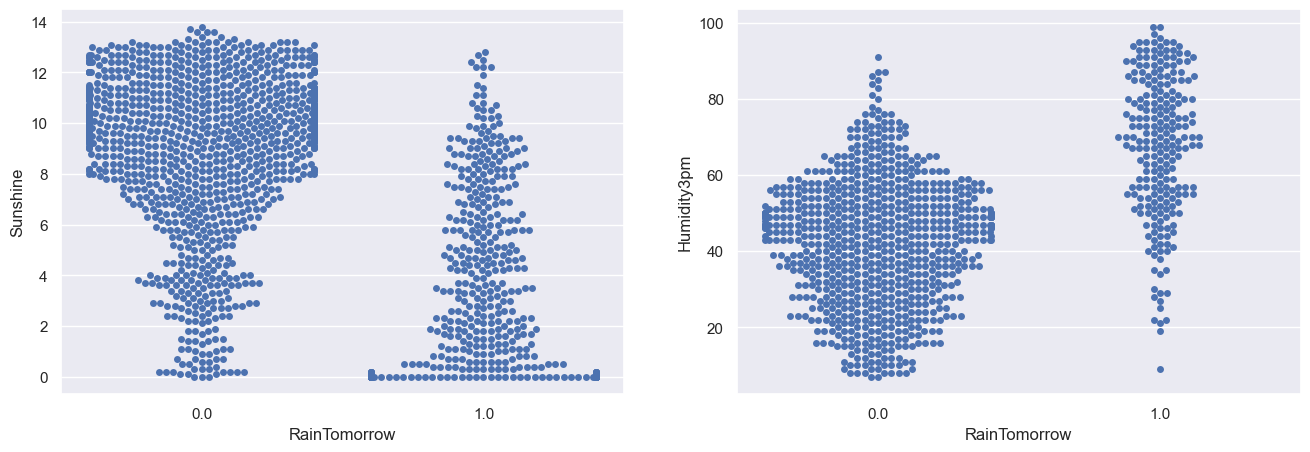

In [30]:
fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
_ = sns.swarmplot(x="RainTomorrow", y="Sunshine", data=df.head(10000), ax=axs[0])
_ = sns.swarmplot(x="RainTomorrow", y="Humidity3pm", data=df.head(1000), ax=axs[1])

Для оценки качества классификации воспользуемся реализованными в sklearn logloss и ROC AUC. ROC AUC является метрикой по умолчанию для бинарной классификации, поскольку очень устойчива к несбалансированности классов. Подробнее про неё можно прочитать https://alexanderdyakonov.wordpress.com/2017/07/28/auc-roc-площадь-под-кривой-ошибок/ . Обучим  логистическую регрессию на вещественных признаках, не подбирая константу регуляризации

In [31]:
from sklearn.metrics import log_loss, roc_auc_score

In [32]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train[numeric_features], y_train)

LogisticRegression(max_iter=1000)

In [33]:
y_pred = model.predict_proba(X_test[numeric_features])[:, 1]
y_train_pred = model.predict_proba(X_train[numeric_features])[:, 1]

print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Train logloss = %.4f" % log_loss(y_train, y_train_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, y_pred))
print("Train roc auc score = %.4f" % roc_auc_score(y_train, y_train_pred))

Test logloss = 0.3650
Train logloss = 0.3689
Test roc auc score = 0.8588
Train roc auc score = 0.8571


### **Вопрос 7** (2 балла)

Сколько итераций понадобилось для обучения логистической регрессии?

***Ваш ответ***

In [34]:
#Ваш ответ

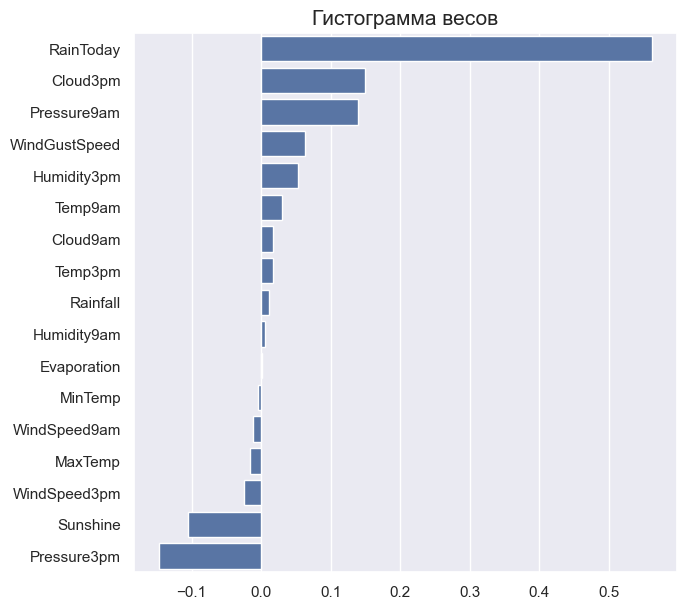

In [35]:
plt.figure(figsize=(7, 7))
sorted_weights = sorted(zip(model.coef_[0], numeric_features), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
_ = sns.barplot(y=features, x=weights).set_title("Гистограмма весов", size=15)

Если приглядеться к весам, то можно увидеть, что между корреляциями признаков с целевой переменной и значением соответствующих весов мало общего. Чтобы это предотвратить, будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени.

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

In [37]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

### **Вопрос 8** (2 балла)

А сколько итераций потребовалось теперь? Как это связано с модельными примерами, на которых мы разбирали разные методы оптимизации?

***Ваш ответ***

In [38]:
#Ваш ответ

In [39]:
y_pred = model.predict_proba(X_test_scaled)[:, 1]
y_train_pred = model.predict_proba(X_train_scaled)[:, 1]

print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Train logloss = %.4f" % log_loss(y_train, y_train_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, y_pred))
print("Train roc auc score = %.4f" % roc_auc_score(y_train, y_train_pred))

Test logloss = 0.3592
Train logloss = 0.3636
Test roc auc score = 0.8646
Train roc auc score = 0.8625


### **Вопрос 9** (2 балла)

Сравните получившееся качество с качеством до нормализации. Объясните, почему оно изменилось, хотя мы применяли линейную модель к линейно преобразованным признакам? Могло ли качество измениться в другую сторону?

***Ваш ответ***

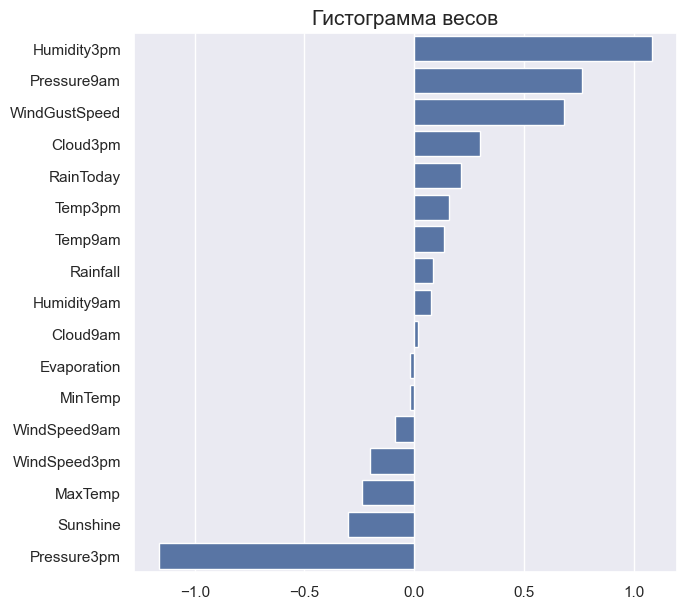

In [40]:
plt.figure(figsize=(7, 7))
sorted_weights = sorted(zip(model.coef_[0], numeric_features), reverse=True)
weights = [x[0] for x in sorted_weights]
features = [x[1] for x in sorted_weights]
_ = sns.barplot(y=features, x=weights).set_title("Гистограмма весов", size=15)

### **Вопрос 10** (2 балла)

Почему даже после нормализации график не до конца похож на гистограмму корреляций?

***Ваш ответ***

Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гиперпараметры. У нашей модели это alpha — коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем alpha по логарифмической сетке, чтобы узнать оптимальный порядок величины).

### **Вопрос 11** (2 балла)
Чем отличаются валидационная и тестовая выборки?

**Ваш ответ**

Best C = 17.0125


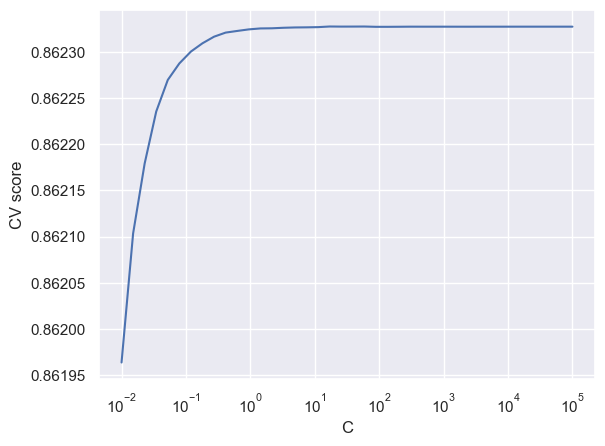

In [41]:
from sklearn.model_selection import GridSearchCV

C = np.logspace(-2, 5, 40)
searcher = GridSearchCV(LogisticRegression(solver='lbfgs'), [{"C": C}], scoring="roc_auc", cv=10, n_jobs=-1)
searcher.fit(X_train_scaled, y_train)

best_C = searcher.best_params_["C"]

print("Best C = %.4f" % best_C)

_ = plt.plot(C, searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")
plt.show()

### **Вопрос 12** (2 балла)

Почему с ростом $C$ качество не падает, хотя модель должна недообучаться?

***Подсказка***: Внимательно прочитайте документацию к реализации логистической регрессии в sklearn

***Ваш ответ***

### **Вопрос 13** (1 балл)

Почему мы не подбираем коэффициент регуляризации по обучающей выборке? По тестовой выборке?

***Ваш ответ***

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся удобным классом Pipeline: обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод fit, а для тестовой — transform), а затем обучить/применить модель (для обучающей fit, а для тестовой — predict). Pipeline позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую. Однако, если ваши модели не укладываются в использование простых fit, transform и predict, то этот класс вам не подойдёт

In [42]:
from sklearn.preprocessing import OneHotEncoder

In [43]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('classification', LogisticRegression(solver='lbfgs', C=best_C))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict_proba(X_test[numeric_features])[:, 1]
print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, y_pred))

Test logloss = 0.3592
Test roc auc score = 0.8646


### **Вопрос 14** (2 балла)

Почему качество не выросло?

***Ваш ответ***

In [44]:
#Ваш ответ

Рассмотрим теперь категориальные признаки. Сразу отметим, что признак "Date" очень опасен, и лучше пока его выкинуть. Это связано с тем, что мы можем получить прямую информацию о том, будет ли завтра дождь, если текущее место и завтрашняя дата встречались где-то в обучающей выборке. Очень часто также встречаются признак наподобие "ID", которые могут содержать аналогичные утечки информации. С такими признаками всегда нужно обращаться осторожно!

In [45]:
categorical = list(X_train.drop(columns=["Date"]).dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

Для работы с категориальными признаками нужно их как-то закодировать числами. Для этого нам понадобится class OneHotEncoder. Вообще OneHotEncoding &mdash; самая стандартная процедура для кодирования категориальных признаков. Помимо библиотеки sklearn, встроенный OneHotEncoder есть в библиотеке pandas и называется get_dummies.

In [46]:
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('classification', LogisticRegression(solver='lbfgs', max_iter=200))
])

model = pipeline.fit(X_train.drop(columns=["Date"]), y_train)
y_pred = model.predict_proba(X_test.drop(columns=["Date"]))[:, 1]
print("Test logloss = %.4f" % log_loss(y_test, y_pred))
print("Test roc auc score = %.4f" % roc_auc_score(y_test, y_pred))

Test logloss = 0.3516
Test roc auc score = 0.8700


Качество немного выросло, если смотреть на ROC AUC!

**Выводы** Во второй части задания по линейным моделям мы должны были узнать:
.

1.   Зачем нужно нормализовать данные.
2.   Как работать с вещественными и категориальными признаками.
3.   Как интерпретировать результат обучения линейной модели, опираясь на описание обучающих данных

-----------
<font color="white" style="opacity:0.2023"></font>

### Бонусное задание (2 балла)

Вставьте мем или красивую картинку связанные с чем-то из:


1.   Страна, данные о которой мы анализировали
2.   Линейные модели
3.   Погода
4.   Динозавры